# Image Reshaping 2.0
* Reshaping 1.0 shows how to use Segment model to MNIST and get good results.
* In 2.0 we try to create a new model using multiple Segment models that learn from flatten row or flatten col shapes per image first.

# Initialization

In [66]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import timeit
from tqdm import tqdm

from segment import Segment

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# MNIST test and Test dataset

In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
from torchvision import datasets, transforms

flatten_by_row_transform = transforms.Lambda(lambda x: x.flatten())
flatten_by_col_transform = transforms.Lambda(lambda x: x.permute(0,2,1).flatten())

train_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.RandomRotation(15), #only during training
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.5], [0.5])
])

train_set = datasets.MNIST('data', train=True, download=False, transform=train_transform)
test_set = datasets.MNIST('data', train=False, download=False, transform=test_transform)
print(len(train_set), len(test_set))
print(train_set[0][0].shape, test_set[0][0].shape)


60000 10000
torch.Size([1, 28, 28]) torch.Size([1, 28, 28])


# Decoder

In [305]:
class Decoder(nn.Module):
    r""" Decodes a flatten image given segments and shape.
        image_shape = [depth, width, height]
    """
    def __init__(self, image_shape):
        super().__init__()
        self.image_size = math.prod(image_shape)
        x_in = torch.arange(1, self.image_size+1)/self.image_size #normalized
        # unsqueeze to add a dimension for n_batch and n_segments
        self.x_in_nd = x_in.unsqueeze(-1).unsqueeze(-1)
        # x_in_nd.shape = [image_size, 1, 1]

    def __calc_mask__(self):
        # x_in_nd.shape = [image_size, 1, 1]
        # create mask to find out which one segment each x belongs to.
        # one x value should only fit in one segment
        lt = torch.lt(self.x_in_nd, self.x[:, 1:]) 
        ge = torch.ge(self.x_in_nd, self.x[:, :-1]) 
        mask = (lt & ge)
        #mask.shape = [image_size, n_segments, batch_size]

        # This mask doesn't include x where x is below 1st segment start
        # or after last segment end
        # we create new mask to capture the x values beyond segments
        mask_lt = torch.lt(self.x_in_nd,self.x[:, 0:1]) #x less than 1st segment
        # then do OR with mask so these are included for prediction.
        mask[:, 0:1, :] = mask[:, 0:1, :] | mask_lt

        #do the same for last x of segment
        mask_ge = torch.ge(self.x_in_nd, self.x[:, -1:]) 
        mask[:, -1:, :] = mask[:, -1:, :] | mask_ge

        return mask

    def forward(self, segment_x, segment_y):
        #segment_x.shape,segment_y.shape  = [n_batch, n_segments+1]
        #self.batch_size = segment_x.shape[0] #we don't need this variable
        self.x = segment_x
        self.y = segment_y
       
        mask = self.__calc_mask__()

        divider = (self.x[:, 1:]-self.x[:, :-1])
        #The ratio can get -inf or inf. we need to protect against it
        divider[divider == 0.] = 0.0001

        # Ratio is the segment (y2-y1)/(x2-x1) ratio 
        ratio = (self.y[:, 1:]-self.y[:, :-1])/divider

        ypred = ratio*mask*(self.x_in_nd - self.x[:,:-1]) + mask * self.y[:,:-1]
        #ypred.shape = [image_size, n_segments, batch_size]
        # As only 1 segment should have value for x we can sum on that dim
        ypred = ypred.sum(1)
        return ypred

## Derivation for n_batch = 1

In [148]:
image_size = 12
x_in = torch.arange(1, image_size+1)/image_size
x_in = x_in.unsqueeze(0) # Add a dim to match n_batch
print(x_in.shape) # batch_n, x_n

torch.Size([1, 12])


In [251]:
print(model.x.shape, model.y.shape)
segment_x = model.x.squeeze(-1)
segment_y = model.y.squeeze(-1)
print(segment_x.shape, segment_y.shape)
segment_x

torch.Size([1, 9, 1]) torch.Size([1, 9, 1])
torch.Size([1, 9]) torch.Size([1, 9])


tensor([[-0.0184,  0.0789,  0.1682,  0.3908,  0.4849,  0.5748,  0.8197,  0.9201,
          0.9861]], grad_fn=<SqueezeBackward1>)

In [252]:
x_in_nd = x_in.unsqueeze(-1).unsqueeze(-1) #to compare each x_in with every segment
print(x_in_nd.shape)
lt = torch.lt(x_in_nd, segment_x[:, 1:]) 
ge = torch.ge(x_in_nd, segment_x[:, :-1]) 
mask = (lt & ge)
print(lt.shape, ge.shape)
mask

torch.Size([12, 1, 1])
torch.Size([12, 1, 8]) torch.Size([12, 1, 8])


tensor([[[False,  True, False, False, False, False, False, False]],

        [[False,  True, False, False, False, False, False, False]],

        [[False, False,  True, False, False, False, False, False]],

        [[False, False,  True, False, False, False, False, False]],

        [[False, False, False,  True, False, False, False, False]],

        [[False, False, False, False,  True, False, False, False]],

        [[False, False, False, False, False,  True, False, False]],

        [[False, False, False, False, False,  True, False, False]],

        [[False, False, False, False, False,  True, False, False]],

        [[False, False, False, False, False, False,  True, False]],

        [[False, False, False, False, False, False,  True, False]],

        [[False, False, False, False, False, False, False, False]]])

In [254]:
mask_lt = torch.lt(x_in_nd,segment_x[:, 0:1]) #x less than 1st segment
# then do OR with mask so these are included for prediction.
mask[:,:, 0:1] = mask[:, :, 0:1] | mask_lt
print(mask.shape)
#do the same for last x of segment
mask_ge = torch.ge(x_in_nd, segment_x[:, -1:]) 
#print(mask_ge)
mask[:, :, -1:] = mask[:, :, -1:] | mask_ge
mask

torch.Size([12, 1, 8])


tensor([[[False,  True, False, False, False, False, False, False]],

        [[False,  True, False, False, False, False, False, False]],

        [[False, False,  True, False, False, False, False, False]],

        [[False, False,  True, False, False, False, False, False]],

        [[False, False, False,  True, False, False, False, False]],

        [[False, False, False, False,  True, False, False, False]],

        [[False, False, False, False, False,  True, False, False]],

        [[False, False, False, False, False,  True, False, False]],

        [[False, False, False, False, False,  True, False, False]],

        [[False, False, False, False, False, False,  True, False]],

        [[False, False, False, False, False, False,  True, False]],

        [[False, False, False, False, False, False, False,  True]]])

In [256]:
divider = (segment_x[:,1:] - segment_x[:,:-1])
#The ratio can get -inf or inf. we need to protect against it
divider[divider == 0.] = 0.0001
print(divider.shape)

# Ratio is the segment (y2-y1)/(x2-x1) ratio 
ratio = (segment_y[:,1:] - segment_y[:,:-1])/divider
print(ratio.shape)

ypred = ratio*mask*(x_in_nd - segment_x[:,:-1]) + mask * segment_y[:,:-1]
print(ypred.shape)
ypred = ypred.sum(-1)
print(ypred.shape)

torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([12, 1, 8])
torch.Size([12, 1])


## Derivation for n_batch = 2

In [257]:
# decoder init
image_size = 12
x_in = torch.arange(1, image_size+1)/image_size
#x_in = x_in.unsqueeze(0) # Add a dim to match n_batch
print(x_in.shape) # batch_n, x_n

torch.Size([12])


In [258]:
#input to forward
print(model.x.shape, model.y.shape)
segment_x = model.x.squeeze(-1)
segment_y = model.y.squeeze(-1)
# let us duplicate the segment input to simulate n_batch = 2
segment_x = segment_x.tile(2,1)
segment_y = segment_y.tile(2,1)
print(segment_x.shape, segment_y.shape)
segment_x

torch.Size([1, 9, 1]) torch.Size([1, 9, 1])
torch.Size([2, 9]) torch.Size([2, 9])


tensor([[-0.0184,  0.0789,  0.1682,  0.3908,  0.4849,  0.5748,  0.8197,  0.9201,
          0.9861],
        [-0.0184,  0.0789,  0.1682,  0.3908,  0.4849,  0.5748,  0.8197,  0.9201,
          0.9861]], grad_fn=<RepeatBackward0>)

In [259]:
# forward
# based on batch size repeat x_in rows.
batch_size = segment_x.shape[0]
print(batch_size)
# only 1 change needed
# unsqueeze to add a dimension for n_batch and n_segments
x_in_nd = x_in.unsqueeze(-1).unsqueeze(-1) # shape 12,1,1
print(x_in_nd.shape)

2
torch.Size([12, 1, 1])


In [247]:
# NOT NEEDED
upper_x = segment_x[:, 1:]
print(upper_x.shape)
# unsqueeze to add a dimension for x_in
#upper_x = upper_x.unsqueeze(1)
print(upper_x.shape) #torch.Size([2, 1, 8])
lt = torch.lt(x_in_nd, upper_x) 
print(lt.shape) #torch.Size([2, 12, 8])

torch.Size([2, 8])
torch.Size([2, 8])
torch.Size([12, 2, 8])


In [262]:
# mask
lt = torch.lt(x_in_nd, segment_x[:, 1:]) 
ge = torch.ge(x_in_nd, segment_x[:, :-1]) 
mask = (lt & ge)
print(lt.shape, ge.shape)
mask
mask_lt = torch.lt(x_in_nd,segment_x[:, 0:1]) #x less than 1st segment
# then do OR with mask so these are included for prediction.
mask[:,:, 0:1] = mask[:, :, 0:1] | mask_lt
print(mask.shape)
#do the same for last x of segment
mask_ge = torch.ge(x_in_nd, segment_x[:, -1:]) 
#print(mask_ge)
mask[:, :, -1:] = mask[:, :, -1:] | mask_ge
mask.shape

torch.Size([12, 2, 8]) torch.Size([12, 2, 8])
torch.Size([12, 2, 8])


torch.Size([12, 2, 8])

In [261]:
divider = (segment_x[:,1:] - segment_x[:,:-1])
#The ratio can get -inf or inf. we need to protect against it
divider[divider == 0.] = 0.0001
print(divider.shape)

# Ratio is the segment (y2-y1)/(x2-x1) ratio 
ratio = (segment_y[:,1:] - segment_y[:,:-1])/divider
print(ratio.shape)

ypred = ratio*mask*(x_in_nd - segment_x[:,:-1]) + mask * segment_y[:,:-1]
print(ypred.shape)
ypred = ypred.sum(-1)
print(ypred.shape)

torch.Size([2, 8])
torch.Size([2, 8])
torch.Size([12, 2, 8])
torch.Size([12, 2])


# Test Decoder
* We first train a Segment to reproduce a 1D function, then see if Decoder can use Segment parameters to decode it

tensor(0.0013) tensor(1.) tensor(-0.7915) tensor(6.2456)
tensor(-0.0145) tensor(0.1145)


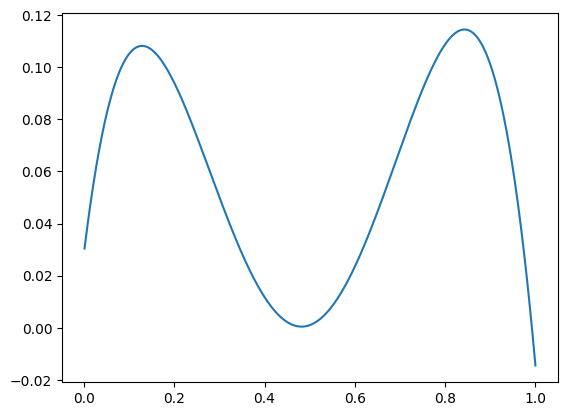

In [264]:
# Create data

# Function to approximate
def f_quartic(x):
    a = -0.0179516
    b = 0.331323
    c = -1.63398
    d = 1.01107
    f = 5.73434
    x = 12.*x -1.2
    return a*x**4 + b*x**3 + c*x**2 + d*x + f

image_size=784
x_in = torch.arange(1, image_size+1)/image_size 
#reshape x_in, ytest
x_in = x_in.unsqueeze(-1)
y_out = f_quartic(x_in)
print(x_in.min(), x_in.max(), y_out.min(), y_out.max())
# normalize y_out
ytest = torch.nn.functional.normalize(y_out, p=2.0, dim=0)
# scale them 
ytest = ytest * 2. 
print(ytest.min(), ytest.max())
plt.plot(x_in, ytest)
plt.show()

In [70]:
# Train a model
model = Segment(x_in.shape[1], ytest.shape[1], 8)

#Initialize model parameters - extremely important.
model.custom_init(x_in.min(dim=0).values, x_in.max(dim=0).values)

criterion = nn.MSELoss(reduction='sum')

lr=.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)

# create dataset that can be used in a dataloader 
dataset = torch.utils.data.TensorDataset(x_in, ytest)
batch_size=64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#Train
num_epochs = 500
losses = np.array([])
for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        # Forward pass
        [X, Y] = data
        ypred = model(X)
        # Calculate the loss
        loss = criterion(ypred, Y)
        train_loss += loss.item()
        
        # Backward and optimize
        model.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    if epoch % (num_epochs/10) == 0:
        losses = np.append(losses, train_loss)
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss))

====> Epoch: 50 Average loss: 0.8111
====> Epoch: 100 Average loss: 0.1500
====> Epoch: 150 Average loss: 0.0287
====> Epoch: 200 Average loss: 0.0082
====> Epoch: 250 Average loss: 0.0051
====> Epoch: 300 Average loss: 0.0045
====> Epoch: 350 Average loss: 0.0042
====> Epoch: 400 Average loss: 0.0039
====> Epoch: 450 Average loss: 0.0037
====> Epoch: 500 Average loss: 0.0036


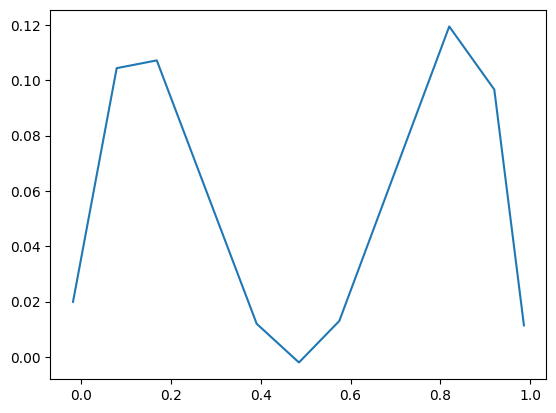

In [269]:
# Plot model params
xval = model.x.reshape(model.x.shape[1]).detach().numpy()
yval = model.y.reshape(model.x.shape[1]).detach().numpy()
plt.plot(xval,yval) 
plt.show()

In [306]:
# Test decoder

decoder = Decoder(image_shape=ytest.shape)
ydecoded = decoder(segment_x=model.x, segment_y=model.y)
ydecoded.shape

torch.Size([784, 1])

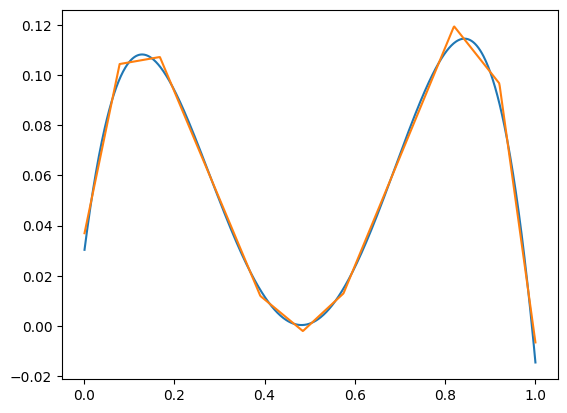

In [307]:
plt.plot(x_in,ytest)
plt.plot(x_in,ydecoded.detach().numpy())

In [281]:
ydecoded.min()

tensor(-0.0020, grad_fn=<MinBackward1>)

In [29]:
image_shape = torch.Tensor([1,2,3])
print(image_shape)
image_size = math.prod(image_shape)
x_in = torch.arange(1, image_size+1)/image_size
print(x_in[0], x_in[-1])
print(x_in)
x_in_4d = x_in.tile((2, 1))  
x_in_4d.unsqueeze(-1).unsqueeze(-1).shape

tensor([1., 2., 3.])
tensor(0.1667) tensor(1.)
tensor([0.1667, 0.3333, 0.5000, 0.6667, 0.8333, 1.0000])


torch.Size([2, 6, 1, 1])

## Model Init

In [ ]:
in_features=784
out_features=10 #classes
segments=10
model = Segment(in_features, out_features, segments).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

criterion = nn.CrossEntropyLoss()

lr=.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)

# create dataset that can be used in a dataloader 
batch_size=64
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

#Initialize model parameters - extremely important.
# as we have normalized valies between -1., 1. we can create a min, max array
x_min = torch.tensor([-1.]*in_features)
x_max = torch.tensor([1.]*in_features)
model.custom_init(x_min, x_max)

In [ ]:
# Train
num_epochs = 40
initalized = False
losses = np.array([])
start = timeit.default_timer()
for epoch in tqdm(range(1, num_epochs+1), position=0, leave=True):
    model.train()
    train_loss = 0
    train_labels = []
    train_preds = []
    for batch_idx, data in enumerate(tqdm(trainloader, position=0, leave=True)):
        # Forward pass
        [X, Y] = data
        ypred = model(X.to(device))
        y_pred_label = torch.argmax(ypred, dim=1)
        train_labels.extend(Y.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        # Calculate the loss
        loss = criterion(ypred, Y.to(device))
        if math.isnan(loss):
            print("Loss is nan")
            break

        train_loss += loss.item()
        
        # Backward and optimize
        model.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    if math.isnan(loss):
        print("Loss is nan")
        break

    train_loss = train_loss/(batch_idx+1)
    losses = np.append(losses, train_loss)
    print("-"*30)
    print(f"Train Accuracy EPOCH {epoch}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print('Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))

    #Run evaluation
    model.eval()
    test_loss = 0
    test_labels = []
    test_preds = []
    for batch_idx, data in enumerate(tqdm(testloader, position=0, leave=True)):
        # Forward pass
        [X, Y] = data
        ypred = model(X.to(device))
        y_pred_label = torch.argmax(ypred, dim=1)
        test_labels.extend(Y.cpu().detach())
        test_preds.extend(y_pred_label.cpu().detach())
        # Calculate the loss
        loss = criterion(ypred, Y.to(device))
        if math.isnan(loss):
            print("Loss is nan")
            break

        test_loss += loss.item()
   
    if math.isnan(loss):
        print("Loss is nan")
        break

    test_loss = test_loss/(batch_idx+1)
    print(f"Epoch: {epoch}, Test Accuracy: {sum(1 for x,y in zip(test_preds, test_labels) if x == y) / len(test_labels):.4f}")
    print('Epoch: {}, Average loss: {:.4f}'.format(epoch, test_loss))
    print("-"*30)


stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")


# Observations of model predicting labels
## Comparable VTI model
* Total parameters: 276298
* Valid Accuracy EPOCH 10: 0.8763
* Valid Accuracy EPOCH 40: 0.9535
* Training Time: 1120.51s

## after flattening images by row
* in_features=784
* out_features=10 #classes
* segments=10
* model = Segment(in_features, out_features, segments).to(device)
* Test Accuracy EPOCH 10: 0.9311
* Epoch: 10 Average loss: 0.2543
* Total parameters: 172480
* Total parameters = 2\*in_features\*out_features\*(segments+1)

## after flattening by column
* Epoch: 10, Test Accuracy: 0.9315
* Epoch: 10, Average loss: 0.2545
* Training Time (10 epoc): 319.26s
* Training Time (40 epoc): 1222.40s
* Test Accuracy never went higher than 93.40 though Train Accuracy went to 97.66

## Adding rotation transform to perturb image 
* Train Accuracy EPOCH 40: 0.9358
* Epoch: 40, Test Accuracy: 0.9360
* Training Time: 1632.88s

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

In [ ]:
# Save graph to a file
#!pip install torchviz
from torchviz import make_dot

# Generate a Graphviz object from the computation graph
graph = make_dot(loss, params=dict(model.named_parameters())) 

# Save the graph as a PDF or any other format if needed
graph.render("model_Segment_test_graph")

In [ ]:
model.x.shape
784*11*10*2

In [ ]:
ytest.min(), ytest.max()